In [1]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/lixiang16/6040project/master/project_excel_themes/gd/csv/mf.csv')


In [3]:
to_drop =['a','b','c','d','e']
data.drop(to_drop, inplace=True, axis=1)

In [4]:
data.dropna(axis=1, how='all')#remove all NaN value

,comments
0,"Unfortunately, I have witnessed a very ""boys c..."
1,The main area I notice a lack of gender divers...
2,I believe that there are efforts from the lowe...
3,it's not just about the gender but also divers...
4,We need to employ/retain or promote women at t...
...,...
159,My perception is the issues are heaviest at th...
160,I'm too new at XXX to comment.
161,There has been an absence of *competent* women...
162,"There are a lot of female employees, but most ..."


In [5]:
data.apply(lambda x: x.astype(str).str.lower())#change all characters in lowercase

,comments
0,"unfortunately, i have witnessed a very ""boys c..."
1,the main area i notice a lack of gender divers...
2,i believe that there are efforts from the lowe...
3,it's not just about the gender but also divers...
4,we need to employ/retain or promote women at t...
...,...
159,my perception is the issues are heaviest at th...
160,i'm too new at xxx to comment.
161,there has been an absence of *competent* women...
162,"there are a lot of female employees, but most ..."


In [6]:

from langdetect import detect
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


D:\anaconda\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
print(data)

                                              comments
0    Unfortunately, I have witnessed a very "boys c...
1    The main area I notice a lack of gender divers...
2    I believe that there are efforts from the lowe...
3    it's not just about the gender but also divers...
4    We need to employ/retain or promote women at t...
..                                                 ...
159  My perception is the issues are heaviest at th...
160                     I'm too new at XXX to comment.
161  There has been an absence of *competent* women...
162  There are a lot of female employees, but most ...
163                                                NaN

[164 rows x 1 columns]


In [8]:
data = data.dropna().reset_index(drop=True)

In [9]:
data

,comments
0,"Unfortunately, I have witnessed a very ""boys c..."
1,The main area I notice a lack of gender divers...
2,I believe that there are efforts from the lowe...
3,it's not just about the gender but also divers...
4,We need to employ/retain or promote women at t...
...,...
158,I have seen so many strong director level wome...
159,My perception is the issues are heaviest at th...
160,I'm too new at XXX to comment.
161,There has been an absence of *competent* women...


In [10]:
#tokenization for the first 3 sentences of the first article
from nltk.tokenize import sent_tokenize

In [11]:

data['sentences'] = data.comments.progress_map(sent_tokenize)
data['sentences'].head(1).tolist()[0][:3] # Print the first 3 sentences of the 1st article


['Unfortunately, I have witnessed a very "boys club" atmosphere at XXX']

In [12]:
from nltk.tokenize import word_tokenize
data['tokens_sentences'] = data['sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
print(data['tokens_sentences'].head(1).tolist()[0][:3])


[['Unfortunately', ',', 'I', 'have', 'witnessed', 'a', 'very', '``', 'boys', 'club', "''", 'atmosphere', 'at', 'XXX']]


In [13]:
#Lemmatizing with POS tagging
from nltk import pos_tag
data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])
print(data['POS_tokens'].head(1).tolist()[0][:3])



[[('Unfortunately', 'RB'), (',', ','), ('I', 'PRP'), ('have', 'VBP'), ('witnessed', 'VBN'), ('a', 'DT'), ('very', 'RB'), ('``', '``'), ('boys', 'NNS'), ('club', 'NN'), ("''", "''"), ('atmosphere', 'RB'), ('at', 'IN'), ('XXX', 'NN')]]


In [14]:
# https://stackoverflow.com/a/15590384
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [15]:
# Lemmatizing each word with its POS tag, in each sentence
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

In [16]:
data['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

[['Unfortunately',
  ',',
  'I',
  'have',
  'witness',
  'a',
  'very',
  '``',
  'boy',
  'club',
  "''",
  'atmosphere',
  'at',
  'XXX']]

In [17]:

from nltk.corpus import stopwords
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['xxx','one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something','often','always']
my_stopwords = stopwords.words('English') + stopwords_verbs + stopwords_other

In [18]:

from itertools import chain # to flatten list of sentences of tokens into list of tokens

In [19]:

data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

In [20]:

data['tokens'].head(1).tolist()[0]

['unfortunately', 'witness', 'boy', 'club', 'atmosphere']

In [21]:
#LDA data preparation 
from gensim.models import Phrases

In [22]:

tokens = data['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

In [23]:
#prepare objects for LDA gensim implementation
from gensim import corpora
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

In [24]:
#Running LDA
from gensim import models
import numpy as np

In [68]:
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
id2word = corpora.Dictionary(data_lemmatized)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           per_word_topics=True)


NameError: name 'lemmatization' is not defined

In [65]:
#SOME OUTCOME OF LDA
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.168*"feel" + 0.108*"team" + 0.073*"time" + 0.055*"meeting" + 0.045*"work" + 0.044*"gender_diversity" + 0.027*"across" + 0.027*"first" + 0.026*"diversity" + 0.026*"company" + 0.026*"employee" + 0.026*"male" + 0.026*"men" + 0.026*"example" + 0.026*"organization" + 0.026*"success" + 0.026*"note" + 0.026*"even" + 0.026*"recently" + 0.026*"respect"

1: 0.050*"gender_diversity" + 0.048*"men" + 0.047*"different" + 0.047*"culture" + 0.047*"female" + 0.047*"recognize" + 0.047*"control" + 0.047*"company" + 0.047*"equal" + 0.047*"senior_leadership" + 0.047*"diversify" + 0.047*"look" + 0.047*"workplace" + 0.047*"talent" + 0.047*"promote" + 0.047*"enough" + 0.047*"promotion" + 0.047*"across" + 0.007*"comment" + 0.006*"diversity"

2: 0.094*"level" + 0.047*"leave" + 0.024*"diversity" + 0.024*"place" + 0.024*"senior_leadership_role" + 0.024*"success" + 0.024*"look" + 0.024*"much" + 0.024*"speak" + 0.024*"move" + 0.024*"boy_club" + 0.024*"great" + 0.024*"available" + 0.024*"company" + 0.024*"leade

In [27]:
print(data.comments.loc[2])#test the model

I believe that there are efforts from the lower levels up to promote gender diversity, and at the lower levels we're doing OK, but it's glaringly obvious that as you go up, there are fewer women. And I feel like executive leadership hasn't prioritized fixing that imbalance, but Collector leadership, for example, has.


In [28]:
lda_model[corpus[2]]#significance

[(30, 0.2873602), (37, 0.676101)]

In [29]:
#predicting topics
document = '''I see a lot of Women in low to mid level positions while I see more men in management and upper management.  '''#import a new data 
tokens = word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,6,0.91,"0.061*""men"" + 0.060*""year"" + 0.048*""look"" + 0...."


In [30]:
#Allocation of topics in all documents

In [31]:
topics = [lda_model[corpus[i]] for i in range(len(data))]

In [32]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,NaN,NaN,NaN,NaN,NaN,0.0913012,NaN,NaN,0.869287,NaN


In [33]:

# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [34]:
document_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.000000,0.0
1,0.0,0.000000,0.0,0.0,0.970895,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.000000,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.287364,0.0,0.0,0.0,0.0,0.0,0,0.676098,0.000000,0.0
3,0.0,0.939062,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.000000,0.0
4,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.970895,0.0


In [35]:
# Which document are about topic 1

In [45]:
amount_topics=document_topic.sort_values(22, ascending=False)[22].head(20)

In [46]:
amount_topics

97     0.988663
18     0.958510
138    0.927777
116    0.297308
94     0.173548
0      0.000000
106    0.000000
107    0.000000
108    0.000000
109    0.000000
110    0.000000
111    0.000000
104    0.000000
112    0.000000
113    0.000000
114    0.000000
115    0.000000
117    0.000000
118    0.000000
119    0.000000
Name: 22, dtype: float64

In [47]:
#print the data about the topics
print(data.comments.loc[91])

I think gender diversity is in general improving at lower cohorts and in R&D, but not yet at leadership levels. I know they are trying. 


In [48]:
#the distribution of the topics in all documents


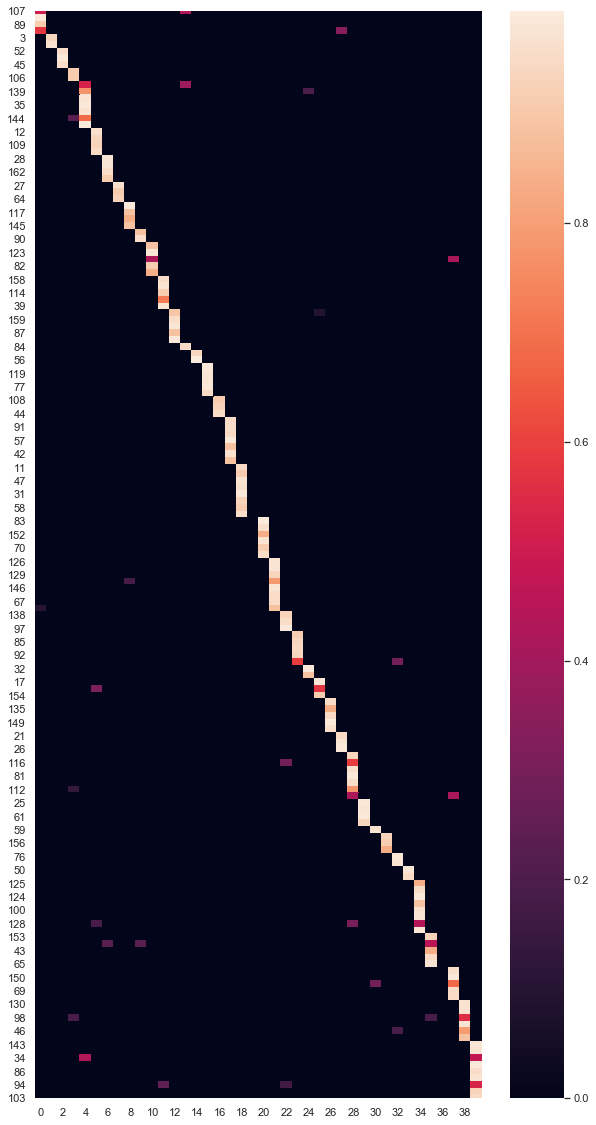

In [40]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

In [41]:
#the sort of topics

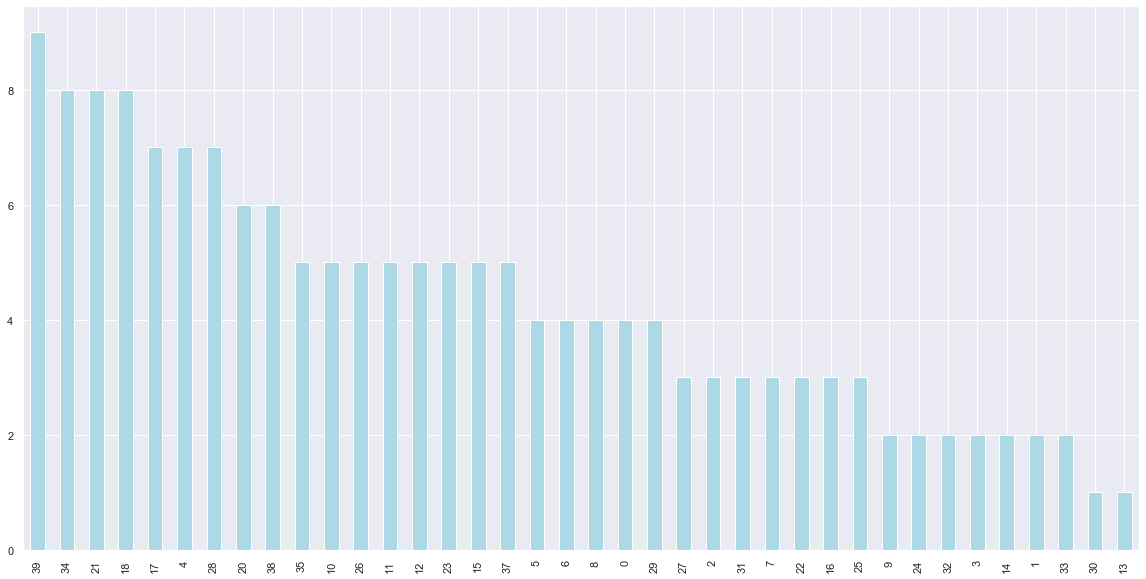

In [42]:
sns.set(rc={'figure.figsize':(20,10)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

In [51]:
#pyLDAvis visualizating topics

In [52]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

D:\anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
